In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import time

In [2]:
comet_api = API(rest_api_key='6O55PoJt4tkp9LyupIE86eikH')
comet_api.get()


['ketrint']

In [3]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

In [4]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [5]:
experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-clustering-new')

In [6]:
exp = experiments[0]

In [7]:
from collections import defaultdict

data = defaultdict(lambda: defaultdict(list))
for exp in experiments:
    good_showers = new_to_old_metric(exp, "Good showers")
    if len(good_showers):
        threshold = float(exp.get_command()[-5])
        min_samples_core = int(get_parameter_by_key(exp, "min_samples_core"))
        data[threshold][min_samples_core].append(good_showers[0])

In [8]:
threshold_data = defaultdict(list)
quality_data = defaultdict(list)
quality_std_data = defaultdict(list)

for threshold in data:
    for min_samples_core in data[threshold]:
        q = data[threshold][min_samples_core]
        threshold_data[min_samples_core].append(threshold)
        quality_data[min_samples_core].append(np.mean(q))
        quality_std_data[min_samples_core].append(np.std(q))

In [20]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')
colors = [
    'skyblue', 'orange', 'steelblue', 'gold', '#f58231', 
]
%matplotlib inline
linewidth = 3



In [21]:
def plot_mean_std(idx, mean, std, label="", i=0):
    idx = np.array(idx)
    mean = np.array(mean)
    std = np.array(std)
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)

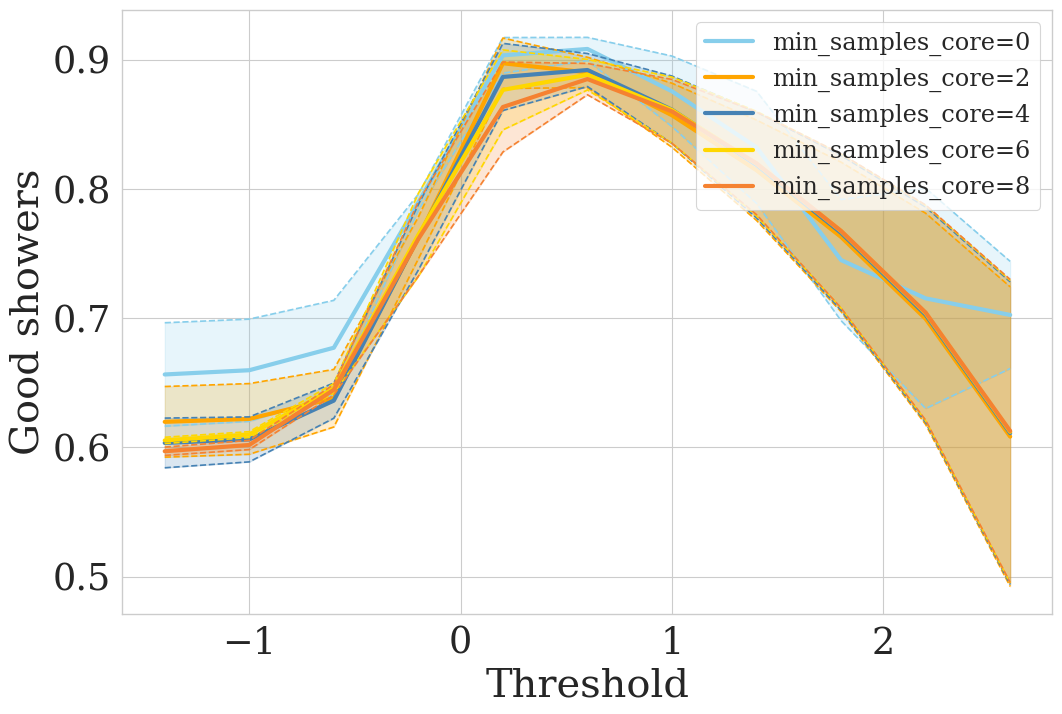

In [31]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
for i, min_samples_core in enumerate(threshold_data):
    plot_mean_std(threshold_data[min_samples_core], quality_data[min_samples_core], 
                  quality_std_data[min_samples_core], label="min_samples_core={}".format(min_samples_core), i=i)
plt.ylabel("Good showers")
plt.xlabel("Threshold")
# plt.ylim
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig("threshold_grid_search_plot.pdf", bbox_inches='tight')
plt.show()

In [23]:
num_epochs = 1500

experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-training')
experiments_balanced = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5'
]
experiments_emulsion = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '0'
]
experiments_edge = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '8'
]

In [24]:
balanced_roc_auc = []
for exp in experiments_balanced:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc.append(roc_auc_test)
balanced_roc_auc = stack_lists(balanced_roc_auc, num_epochs)


edge_roc_auc = []
for exp in experiments_edge:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    edge_roc_auc.append(roc_auc_test)
edge_roc_auc = stack_lists(edge_roc_auc, num_epochs)

emulsion_roc_auc = []
for exp in experiments_emulsion:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    emulsion_roc_auc.append(roc_auc_test)
emulsion_roc_auc = stack_lists(emulsion_roc_auc, num_epochs)

In [25]:
def plot_roc_auc_test(data, label="", i=0):
    idx = np.arange(len(data))
    mean = data.mean(1)
    std = data.std(1) / np.sqrt(data.shape[1])
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)


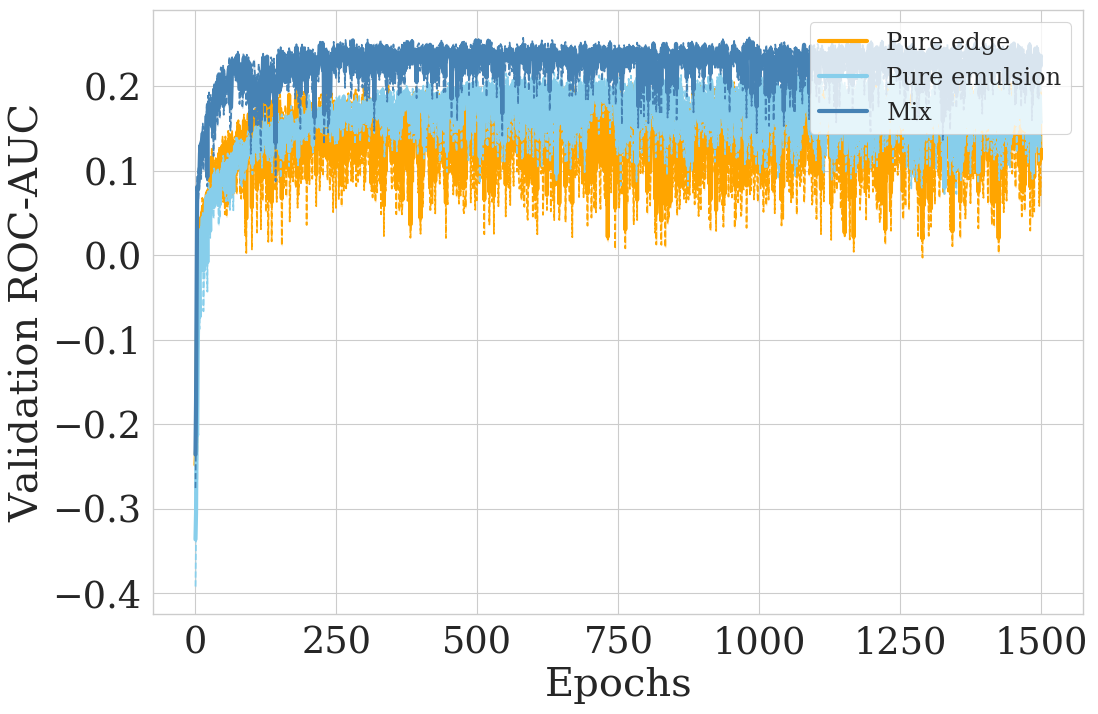

In [29]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
plot_roc_auc_test(edge_roc_auc, i=1, label="Pure edge")
plot_roc_auc_test(emulsion_roc_auc, i=0, label="Pure emulsion")
plot_roc_auc_test(balanced_roc_auc, i=2, label="Mix")

plt.ylabel("Validation ROC-AUC")
plt.xlabel("Epochs")
# plt.ylim
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig("validation_roc_auc.pdf", bbox_inches='tight')
plt.show()

-------

In [1]:
import torch
import torch.nn as nn
from opera_tools import plot_graphx, DISTANCE, scattering_estimation_loss
import matplotlib.pyplot as plt

import networkx

In [2]:
datafile='clusters.pt'
clusters = torch.load(datafile)

In [3]:
clusters['graphx']

In [4]:
len(clusters['clusters'])

189

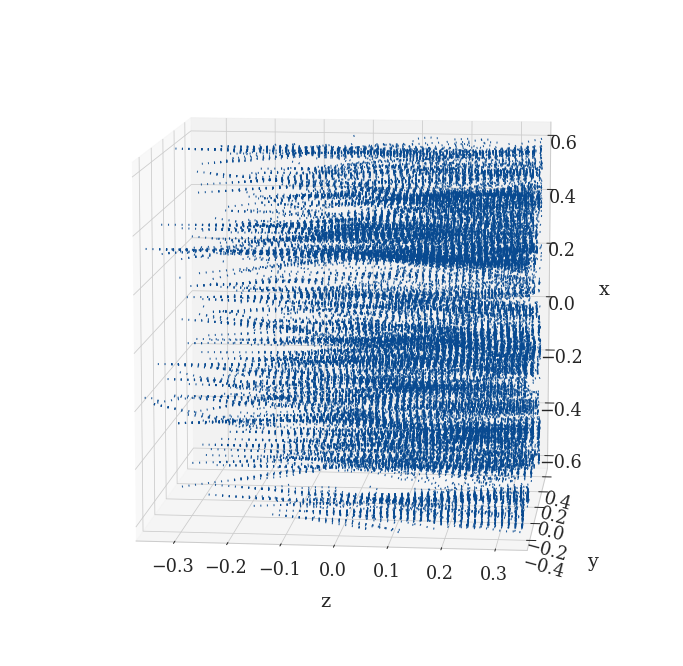

In [5]:
plot_graphx((clusters['graphx']))